# LAB04: Regresion y agrupamientov2
##### Grupo: B05

Si estamos utilizando google colab, en vez de clonar el repositorio, con wget obtenemos el archivo que contiene el dataset

In [21]:
import os

filename = 'wine_alcohol.csv'
url = 'https://github.com/Alf-caput/LAB04_Regresion_y_agrupamiento/raw/main/wine_alcohol.csv'

if not os.path.exists(filename):
    os.system('wget' + ' ' + url)

Junto con las librerías requeridas

In [22]:
import os

requirements = 'requirements.txt'
url = 'https://github.com/Alf-caput/LAB04_Regresion_y_agrupamiento/raw/main/requirements.txt'

if not os.path.exists(requirements):
    os.system('wget' + ' ' + url)

os.system('pip install -r requirements.txt')

Defaulting to user installation because normal site-packages is not writeable


0

Importamos todas las liberías necesarias a lo largo de la práctica:

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
data = pd.read_csv(filename, delimiter=';')
data.head()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,1,9.8
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4


Vamos a quitar la columna id ya que no resulta de utilidad para el análisis al tratarse de un mero identificador

In [25]:
data.drop('id', axis=1, inplace=True)

Vamos a comprobar si hay NaNs en nuestro set de datos:

In [26]:
null_values = data.isnull().sum()
null_values

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
quality                 0
wine type               0
alcohol                 0
dtype: int64

No hay NaNs.

Vamos a visualizar las distribuciones de las variables de nuestro dataset:

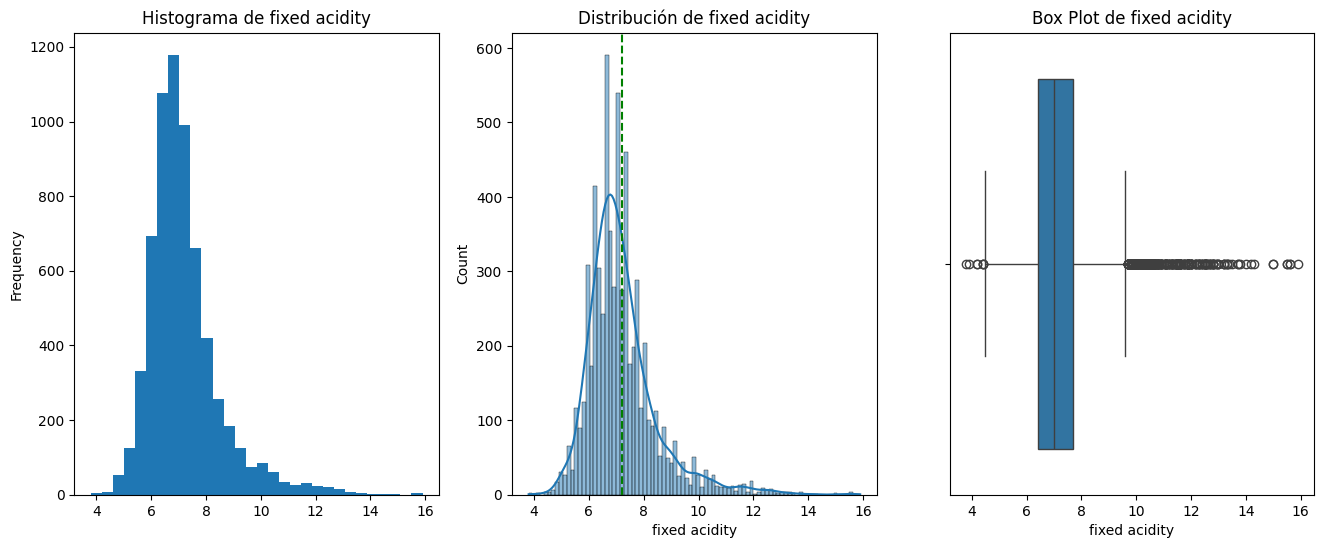

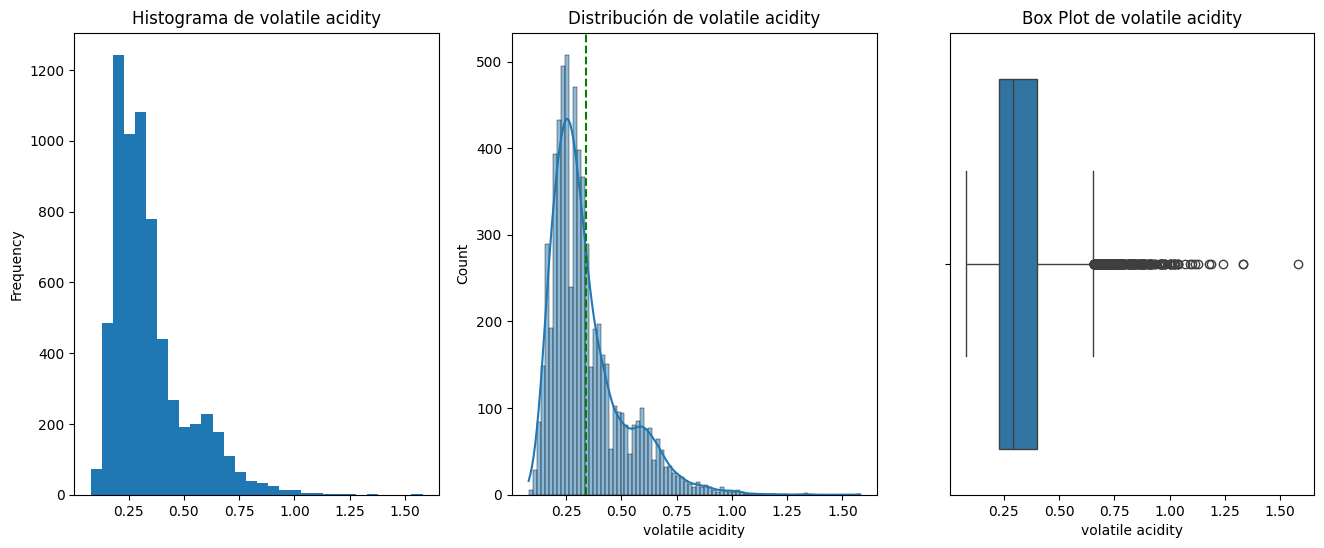

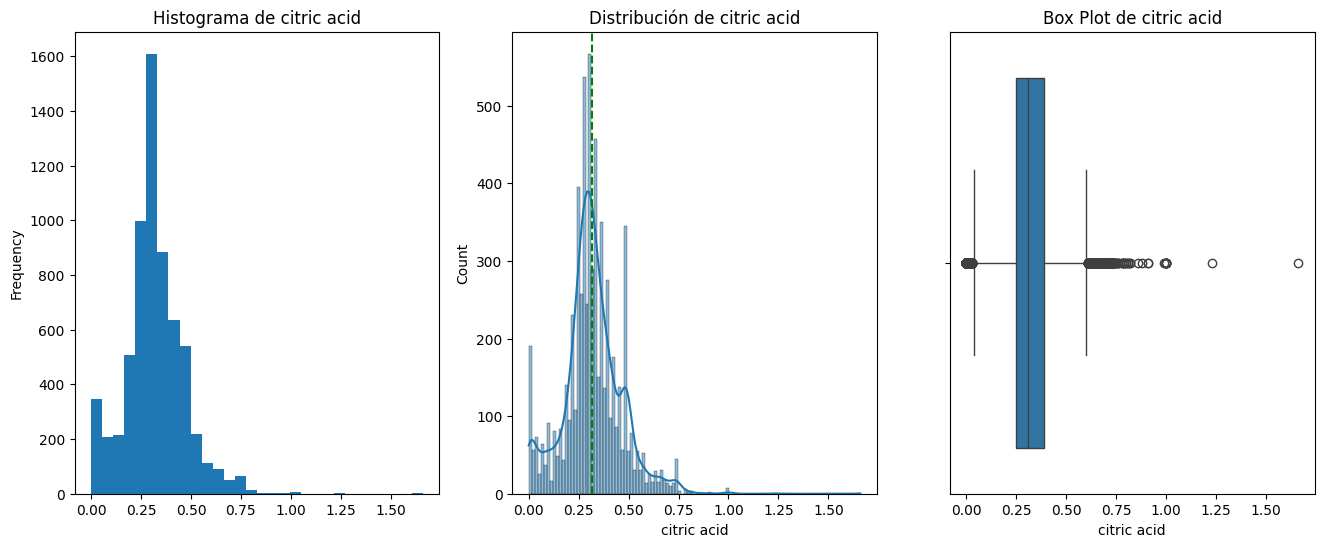

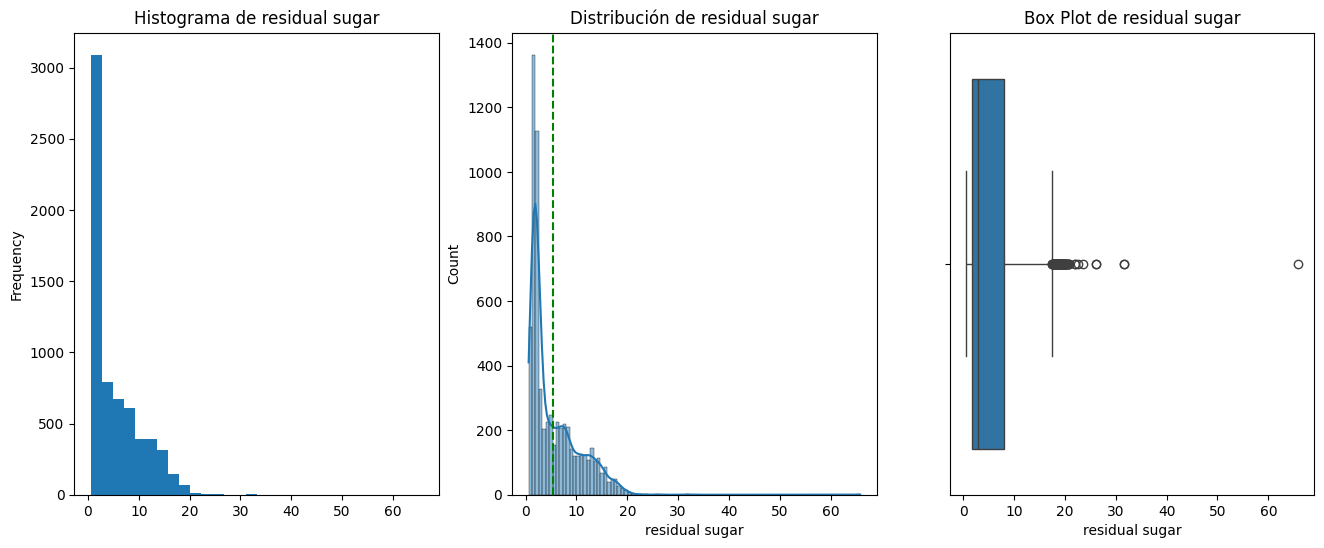

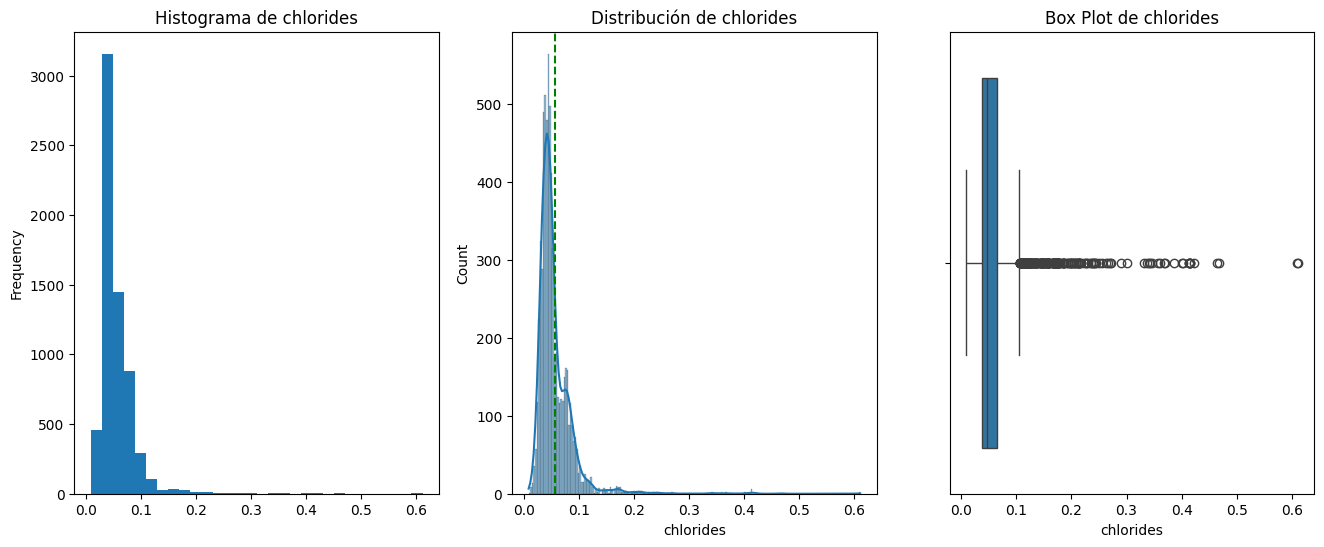

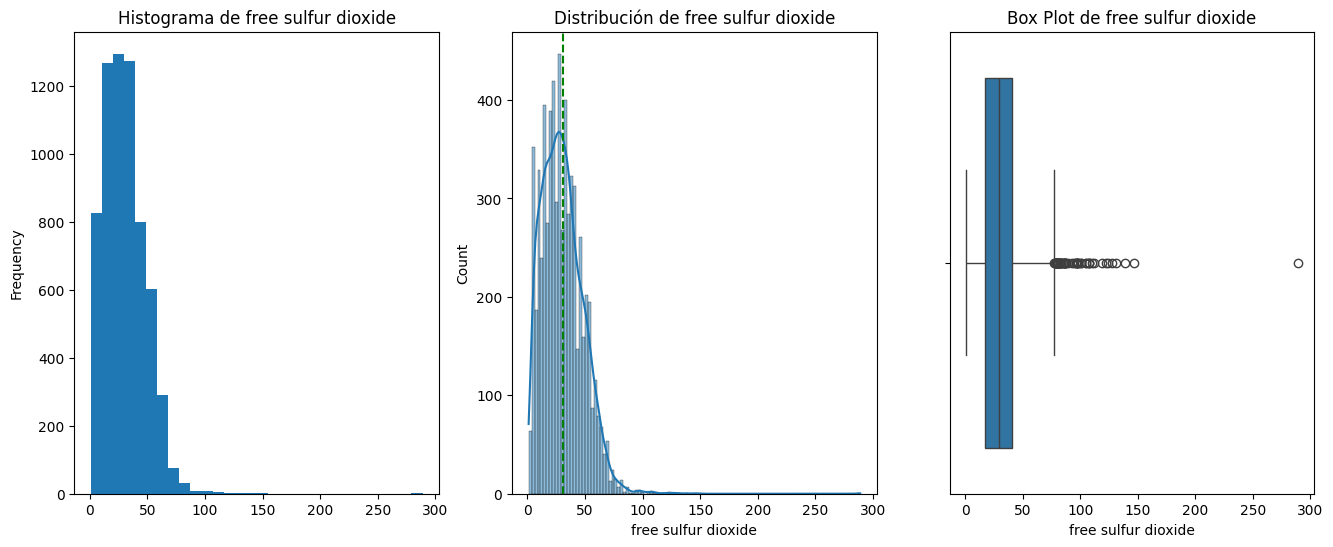

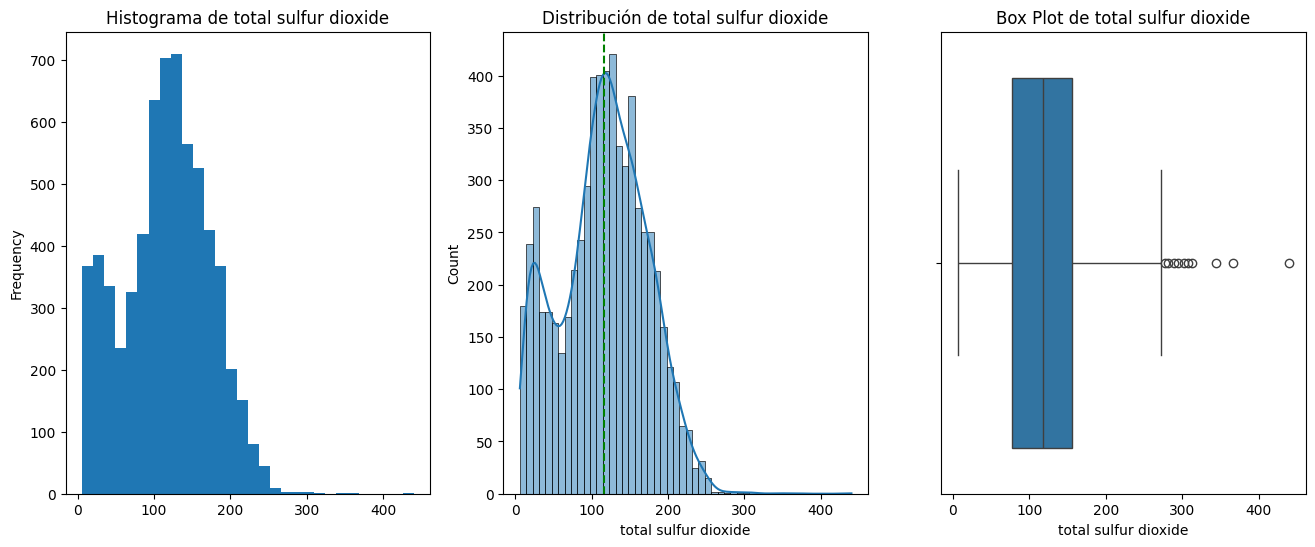

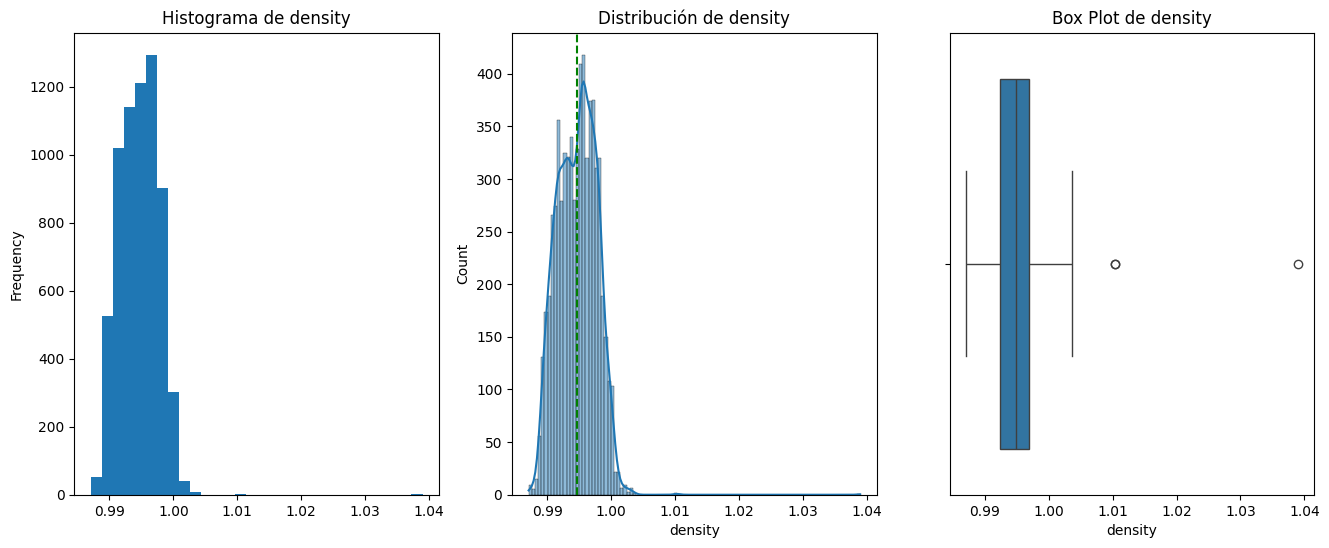

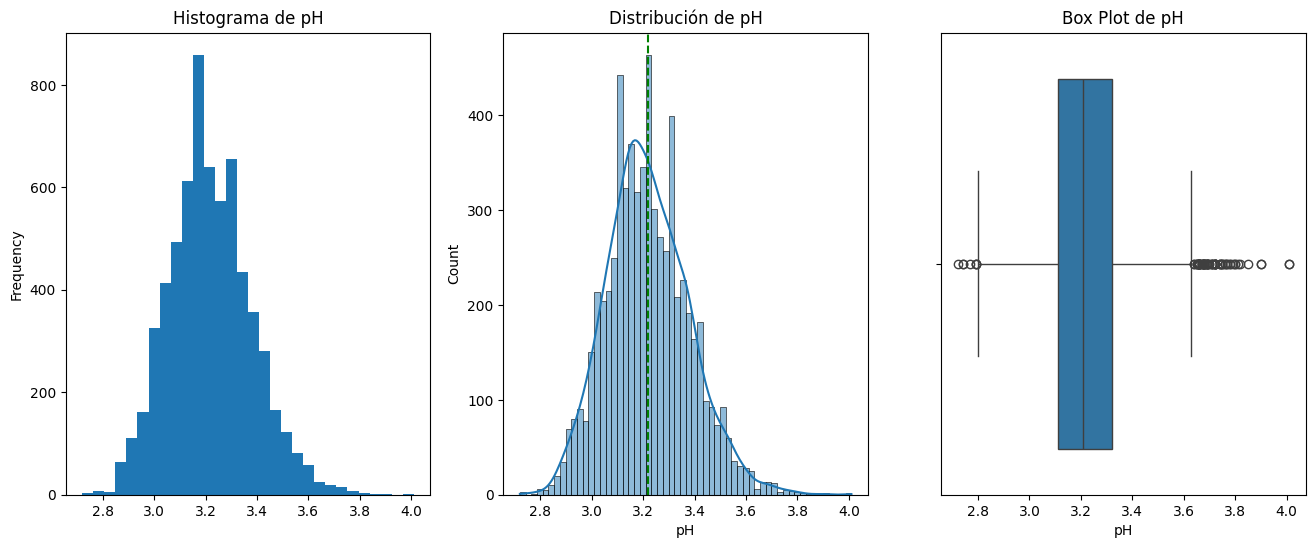

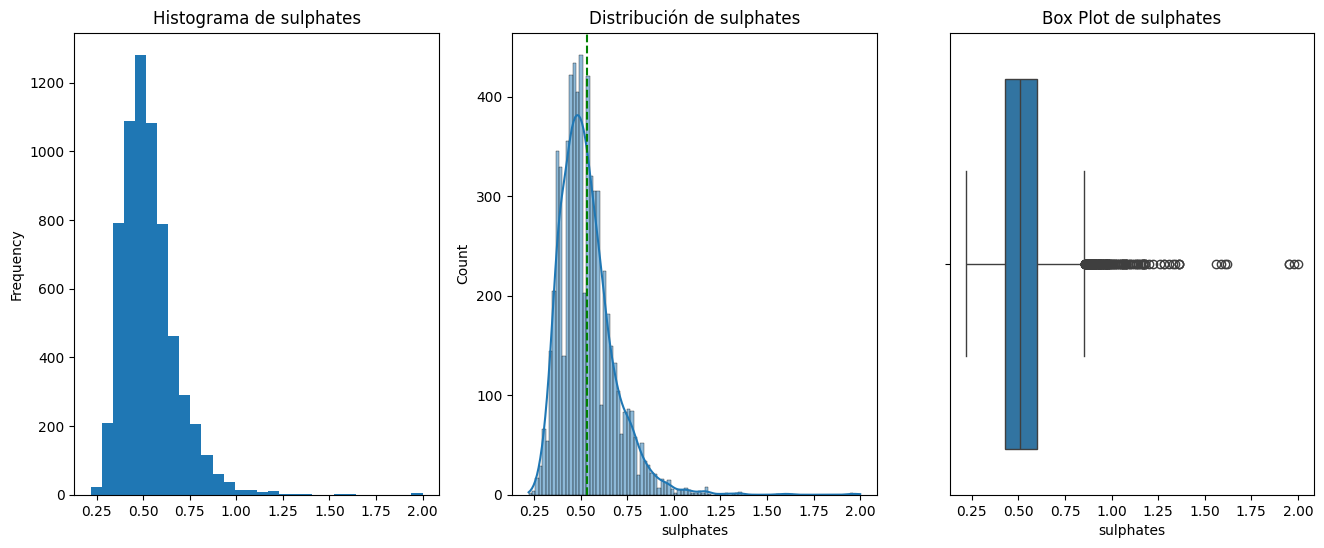

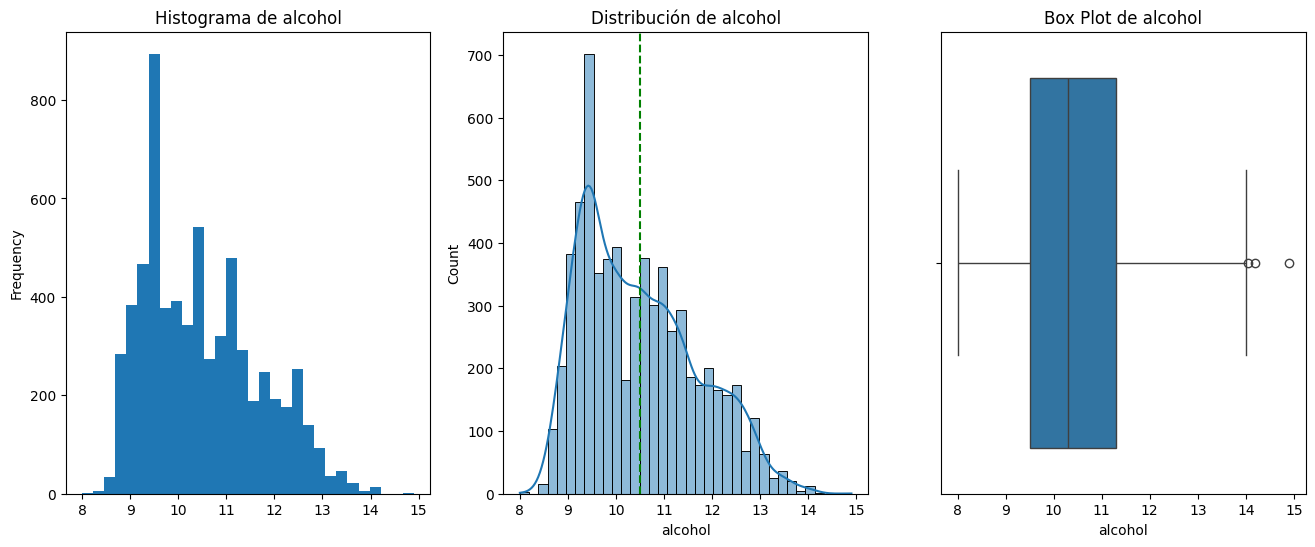

In [27]:
import scipy 
def feat_plot(data, var):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    data[var].plot(kind='hist', bins=30)
    plt.title(f'Histograma de {var}')
    
    plt.subplot(1, 3, 2)
    mu, sigma = scipy.stats.norm.fit(data[var])
    sns.histplot(data[var], kde=True)
    plt.axvline(mu, linestyle='--', color='green')
    plt.title(f'Distribución de {var}')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x=data[var])
    plt.title(f'Box Plot de {var}')
    plt.show()
    
    
numeric_vars = data.select_dtypes(include=['float64', 'int64']).columns.drop(['quality', 'wine type'])  # Excluir id, quality y wine type
for var in numeric_vars:
    feat_plot(data, var)

- Distribuciones Asimétricas: Algunas variables como residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide y alcohol muestran distribuciones altamente asimétricas.
- Distribuciones más simétricas y acotadas: Variables como fixed acidity, pH, density y sulphates parecen tener distribuciones más simétricas y están más concentradas en rangos específicos.
- Variables categóricas: quality y wine type 

La variable quality se trata de una variable numérica discreta que podemos tratar como categórica, además en el diagrama de barras vemos que las clases no están igualmente de representadas, siendo la más frecuente los vinos con calidad 6. Una acción que podemos tomar es agrupar en 3 categorías:

- malo: 3-5
- normal: 6
- bueno: 7-9

Esta agrupación nos permite reducir la dimensionalidad del espacio de valores posibles y conseguir categorías con frecuencias más próximas

/tmp/ipykernel_634/764680567.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'bad' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[bad, var] = 'bad'


<BarContainer object of 3 artists>

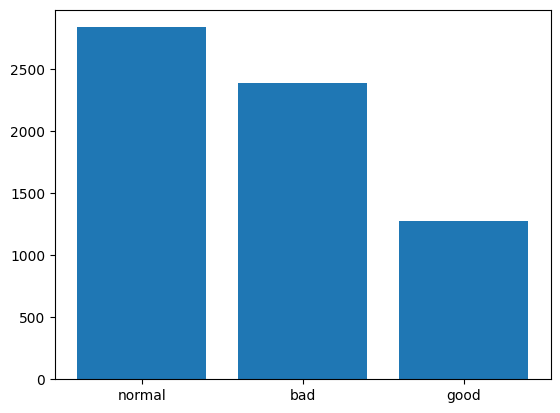

In [28]:
var = 'quality'

bad = data.loc[:, var] <= 5
normal = data.loc[:, var] == 6
good = data.loc[:, var] > 6

data.loc[bad, var] = 'bad'
data.loc[normal, var] = 'normal'
data.loc[good, var] = 'good'

quality_freq = data['quality'].value_counts()
plt.bar(quality_freq.index, quality_freq.values)

Las pasamos a dummies:

In [29]:
data_dummies = pd.get_dummies(data['quality'], prefix='quality')
data = pd.concat([data.drop(columns=['quality']), data_dummies], axis=1)

Convertimos a categórica wine type:

In [30]:
data['wine type'] = data['wine type'].astype('category')

La transformación logarítmica ha ayudado a reducir la asimetría y a manejar los valores extremos de manera más efectiva.

Aplicar la Transformación Logarítmica a las variables con distribuciones sesgadas y presencia de outliers para reducir el sesgo causado por outliers extremos

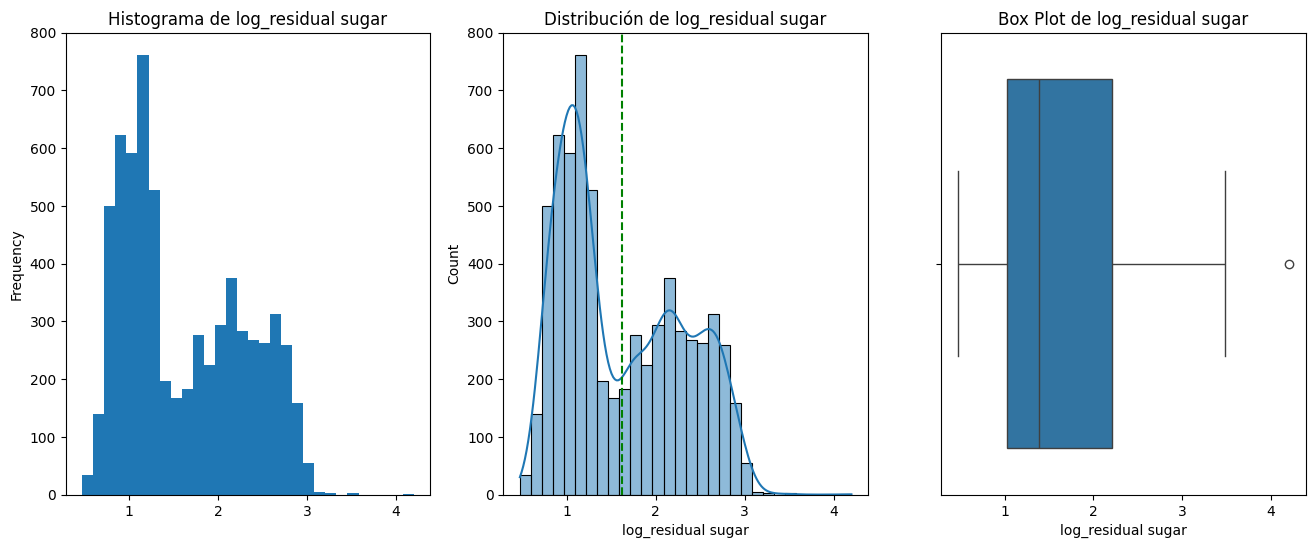

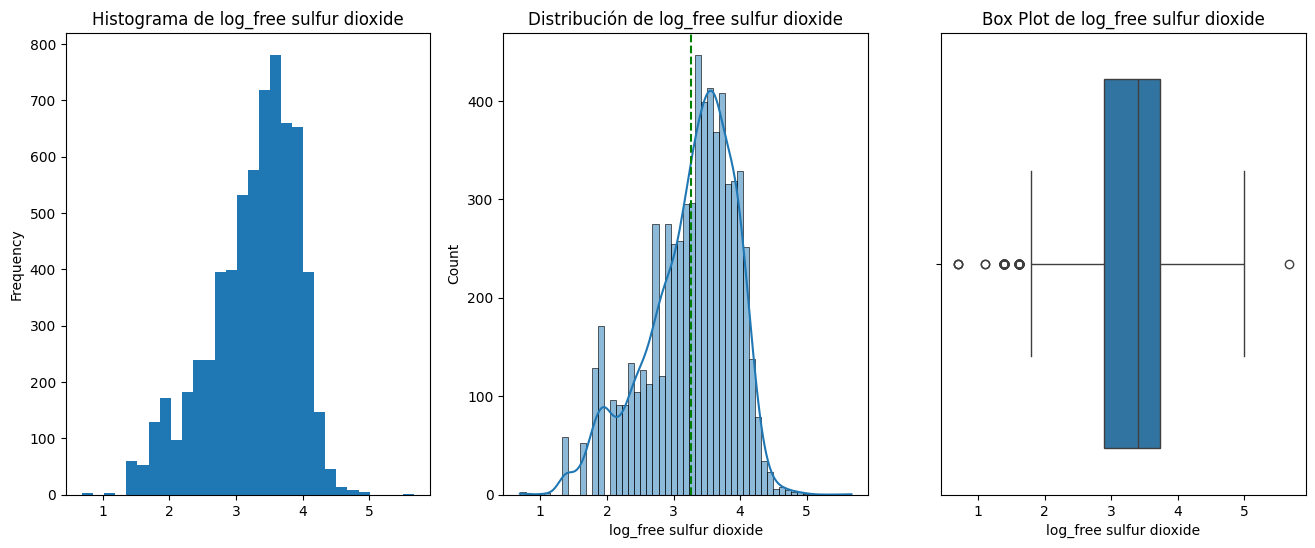

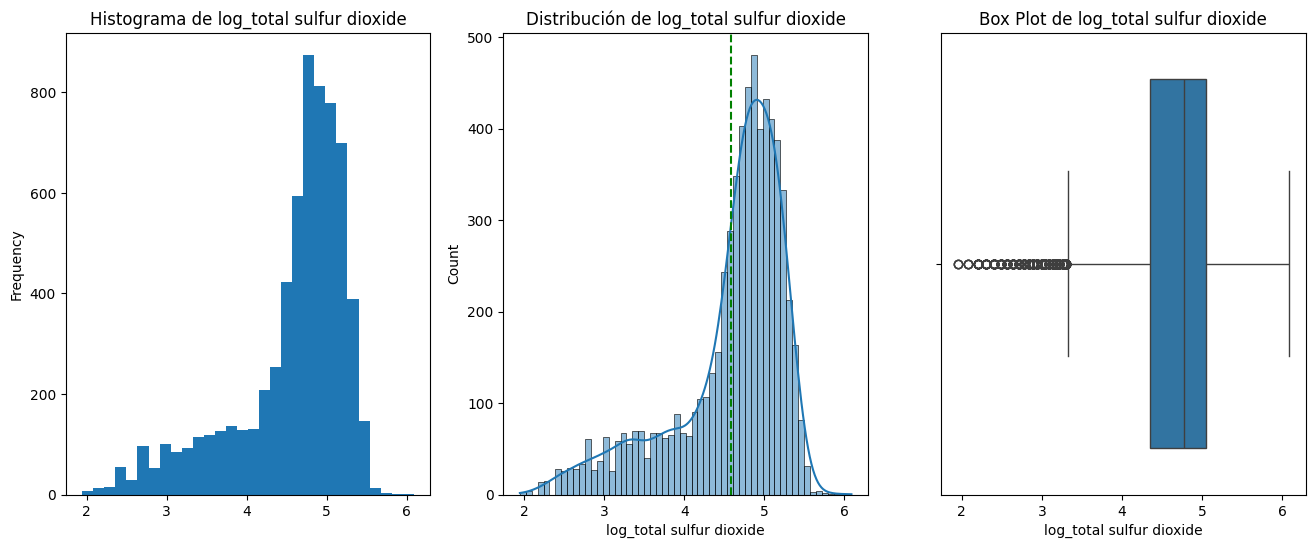

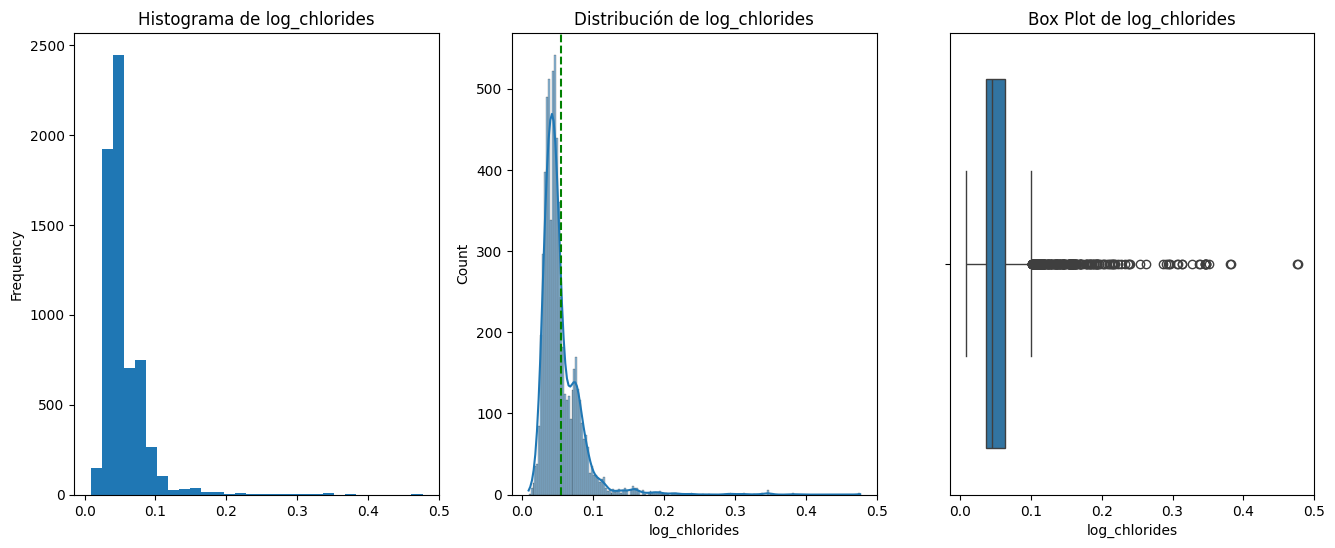

In [31]:
transformed_vars = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'chlorides']
for var in transformed_vars:
    data[f'log_{var}'] = np.log1p(data[var])

for var in transformed_vars:
    feat_plot(data, f'log_{var}')

Eliminamos las observaciones que resulten ser outliers tras la transformación logarítmica:

In [32]:
numeric_columns = data.select_dtypes(include=['float64']).columns
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

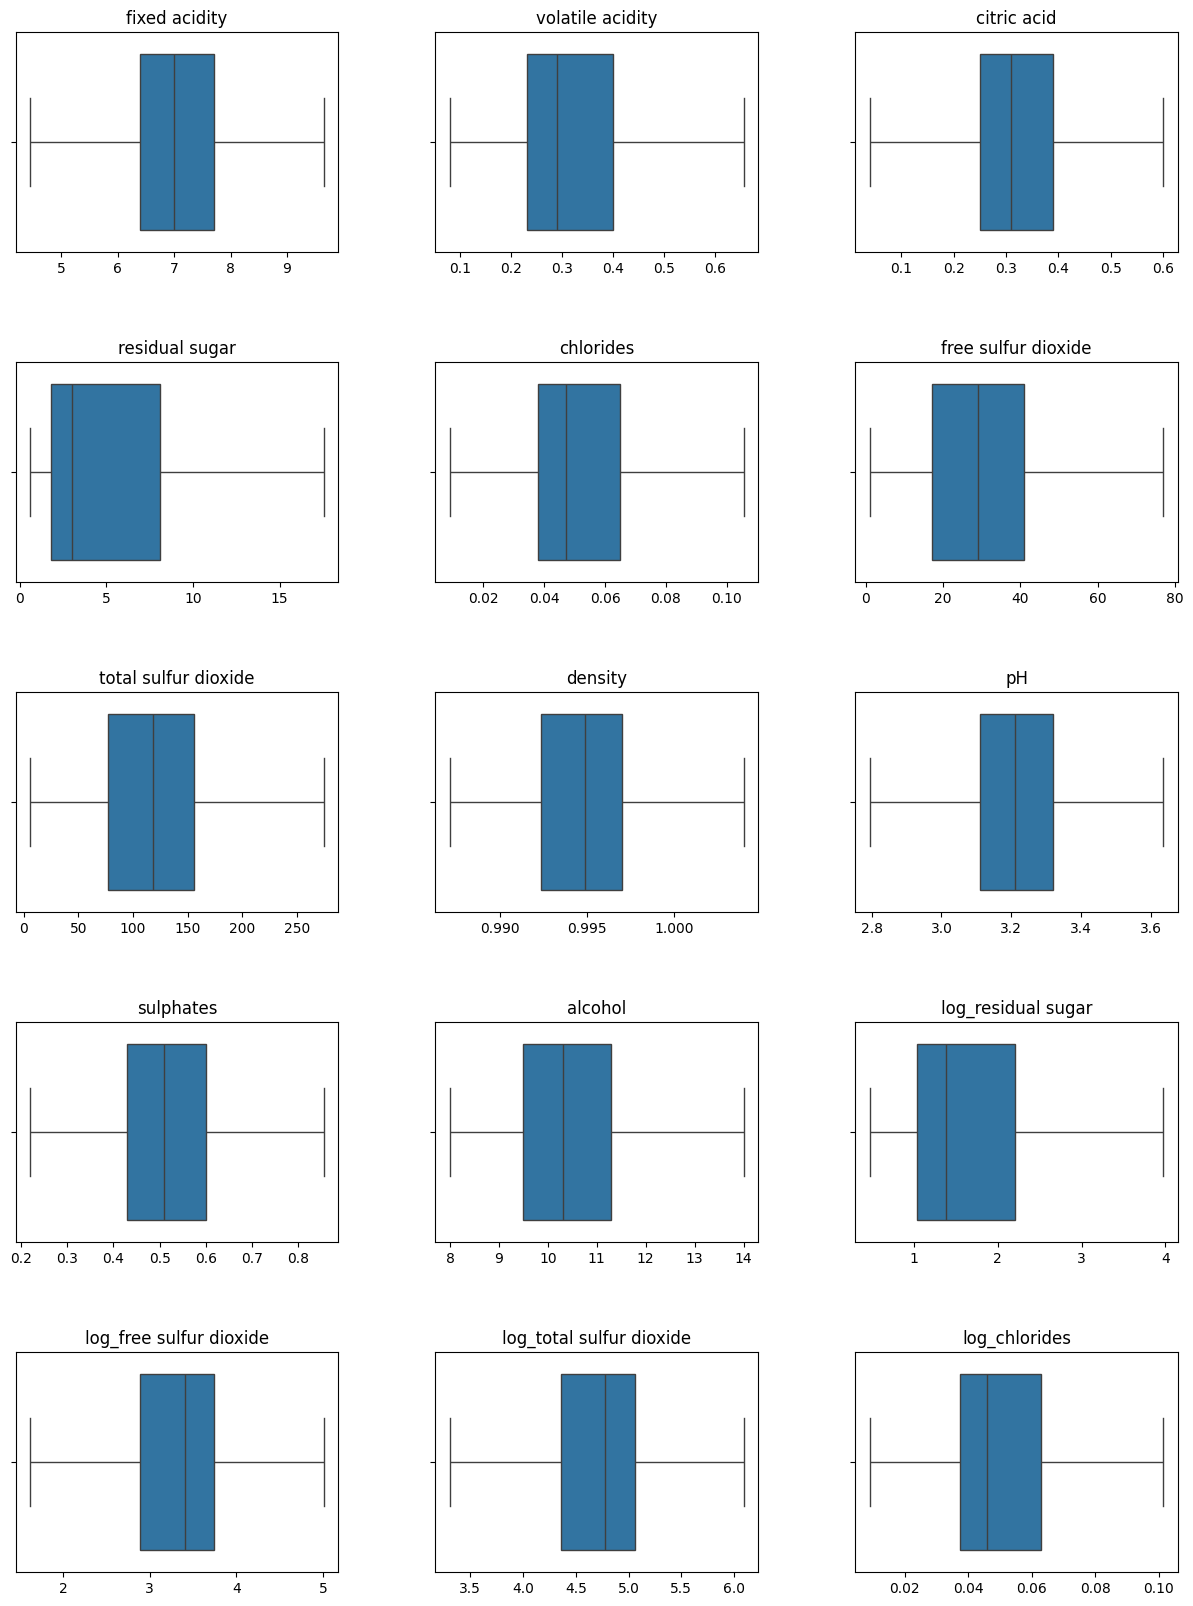

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
axes = axes.ravel()

numeric_columns = data.select_dtypes(include=['float64']).columns

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

for j in range(i+1, 15):
    fig.delaxes(axes[j])

plt.show()

Ponemos todas las observaciones de las variables categóricas en la escala de máximos-mínimos para preservar sus distancias relativas y mejorar la convergencia del algoritmo:

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data[numeric_columns].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,log_residual sugar,log_free sulfur dioxide,log_total sulfur dioxide,log_chlorides
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.517726,0.439325,0.493178,0.283642,0.458340,0.386047,0.408462,0.449676,0.503141,0.482940,0.415271,0.328185,0.486988,0.470151,0.462012
std,0.205015,0.251088,0.235457,0.272195,0.220610,0.222432,0.209520,0.174542,0.187977,0.206608,0.198689,0.194517,0.191008,0.218433,0.217852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375000,0.260870,0.375000,0.070796,0.300518,0.210526,0.264432,0.310294,0.375000,0.330709,0.250000,0.159605,0.375000,0.377225,0.306224
50%,0.490385,0.365217,0.482143,0.141593,0.393782,0.368421,0.417132,0.461584,0.494048,0.456693,0.383333,0.261330,0.525722,0.529083,0.399522
75%,0.625000,0.556522,0.625000,0.442478,0.580311,0.526316,0.558659,0.586176,0.625000,0.598425,0.550000,0.495763,0.625000,0.628709,0.583735
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,wine type,alcohol,quality_bad,quality_good,quality_normal,log_residual sugar,log_free sulfur dioxide,log_total sulfur dioxide,log_chlorides,cluster
0,0.567308,1.000000,0.000000e+00,0.076696,0.694301,0.131579,0.104283,0.634233,0.851190,0.535433,1,0.233333,True,False,False,0.169613,0.255365,0.089136,0.694783,1
1,0.644231,1.000000,0.000000e+00,0.117994,0.922280,0.315789,0.227188,0.574904,0.482143,0.724409,1,0.300000,True,False,False,0.231281,0.483499,0.327901,0.913513,1
2,0.644231,1.000000,4.163336e-17,0.100295,0.860104,0.184211,0.178771,0.586770,0.553571,0.677165,1,0.300000,True,False,False,0.206465,0.340247,0.251625,0.854297,1
3,1.000000,0.347826,9.285714e-01,0.076696,0.683938,0.210526,0.201117,0.646099,0.434524,0.566929,1,0.300000,False,False,True,0.169613,0.375000,0.288848,0.684734,1
4,0.567308,1.000000,0.000000e+00,0.076696,0.694301,0.131579,0.104283,0.634233,0.851190,0.535433,1,0.233333,True,False,False,0.169613,0.255365,0.089136,0.694783,1


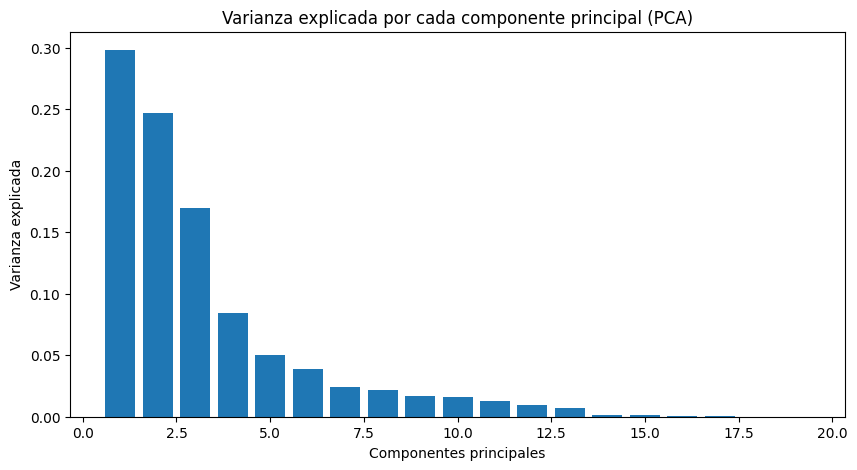

array([2.98217553e-01, 2.46867231e-01, 1.69441766e-01, 8.41365247e-02,
       5.05067007e-02, 3.91270750e-02, 2.37729890e-02, 2.21098200e-02,
       1.67362702e-02, 1.60074552e-02, 1.29406470e-02, 9.25645454e-03,
       6.92091315e-03, 1.70479462e-03, 1.05928759e-03, 6.67779475e-04,
       5.25618303e-04, 1.12103899e-06, 1.59813852e-32])

In [35]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data)
explained_variance = pca.explained_variance_ratio_

# Visualizar la varianza explicada por cada componente principal
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.ylabel('Varianza explicada')
plt.xlabel('Componentes principales')
plt.title('Varianza explicada por cada componente principal (PCA)')
plt.show()

explained_variance

Los tres primeros componentes principales son capaces de explicar en torno al 70% del dataset, por tanto, vamos a emplear dichos componentes para reducir la dimensionalidad.

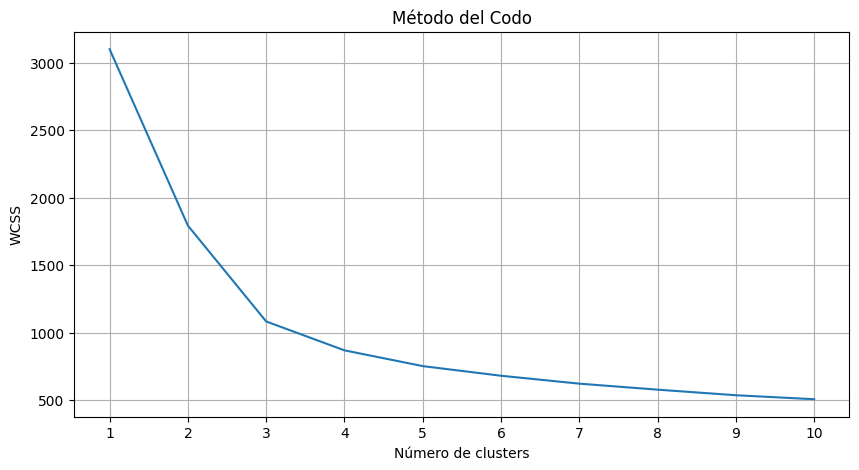

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
principal_components = pca_3d.fit_transform(data[numeric_columns])

wcss = []
for i in range(1, 11):  # Evaluar de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS') 
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

Parece ser que el número óptimo de clusteres serían 3 debido al cambio drástico de la pendiente.

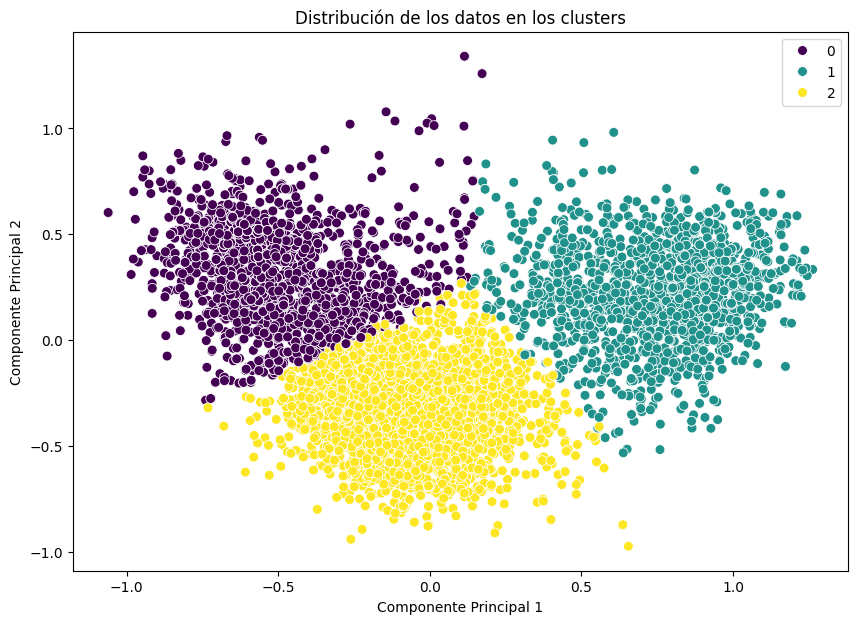

In [37]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(principal_components)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Distribución de los datos en los clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [49]:
quality_columns = [col for col in data.columns if 'quality' in col]
quality_summary = data.groupby('cluster')[quality_columns].sum()
cluster_sizes = data['cluster'].value_counts().sort_index()
quality_proportions = quality_summary.div(cluster_sizes, axis=0)

cluster_summary = numeric_summary.join(quality_proportions)

# Mostrar el resumen extendido
print(cluster_summary)


         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0             0.481116          0.351571     0.550630        0.616835   
1             0.687343          0.731112     0.418755        0.112829   
2             0.447785          0.336182     0.495178        0.148674   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0         0.424842             0.574866              0.602598  0.575439   
1         0.747545             0.190798              0.154745  0.568545   
2         0.319039             0.364886              0.416471  0.295703   

               pH  sulphates   alcohol  log_residual sugar  \
cluster                                                      
0        0.433823   0.426013  0.276017            0.561492   
1        0.599426   0.652624  0.391047            0.212060   
2        0

0. Cluster 0:

- Características químicas: Este cluster tiene niveles moderados de acidez fija, acidez volátil, y citricidad. La cantidad de azúcar residual es alta, así como la densidad y los sulfatos.
- Proporciones de calidad: La mayoría de los vinos en este cluster son calificados como normales (44.5%), seguidos por los vinos malos (43.4%) y una menor proporción de buenos (12.1%). Este cluster podría representar vinos con características balanceadas pero no excepcionales.

1. Cluster 1:
- Características químicas: Este cluster se caracteriza por tener la mayor acidez volátil y los niveles más altos de cloruros, lo que podría indicar vinos más robustos o con posibles defectos. La cantidad de azúcar residual es baja y los niveles de dióxido de azufre son significativamente menores.

- Proporciones de calidad: Predomina una cantidad similar de vinos normales (39.7%) y malos (47.9%), con una pequeña cantidad de buenos (12.4%). Esto sugiere que este cluster 
incluye vinos de peor calidad.

2. Cluster 2:
- Características químicas: Presenta los niveles más bajos de cloruros y una densidad relativamente baja comparada con los otros clusters. Los niveles de ácido cítrico son también moderados, pero mejores que en el cluster 1.

- Proporciones de calidad: Este cluster tiene una mayor diversidad en las calificaciones, con una representación más equilibrada de vinos normales (45.3%) y buenos (28.9%), y la menor proporción de vinos malos (25.8%). Este cluster podría representar vinos de calidad decente, con una mayor propensión hacia características más deseables.

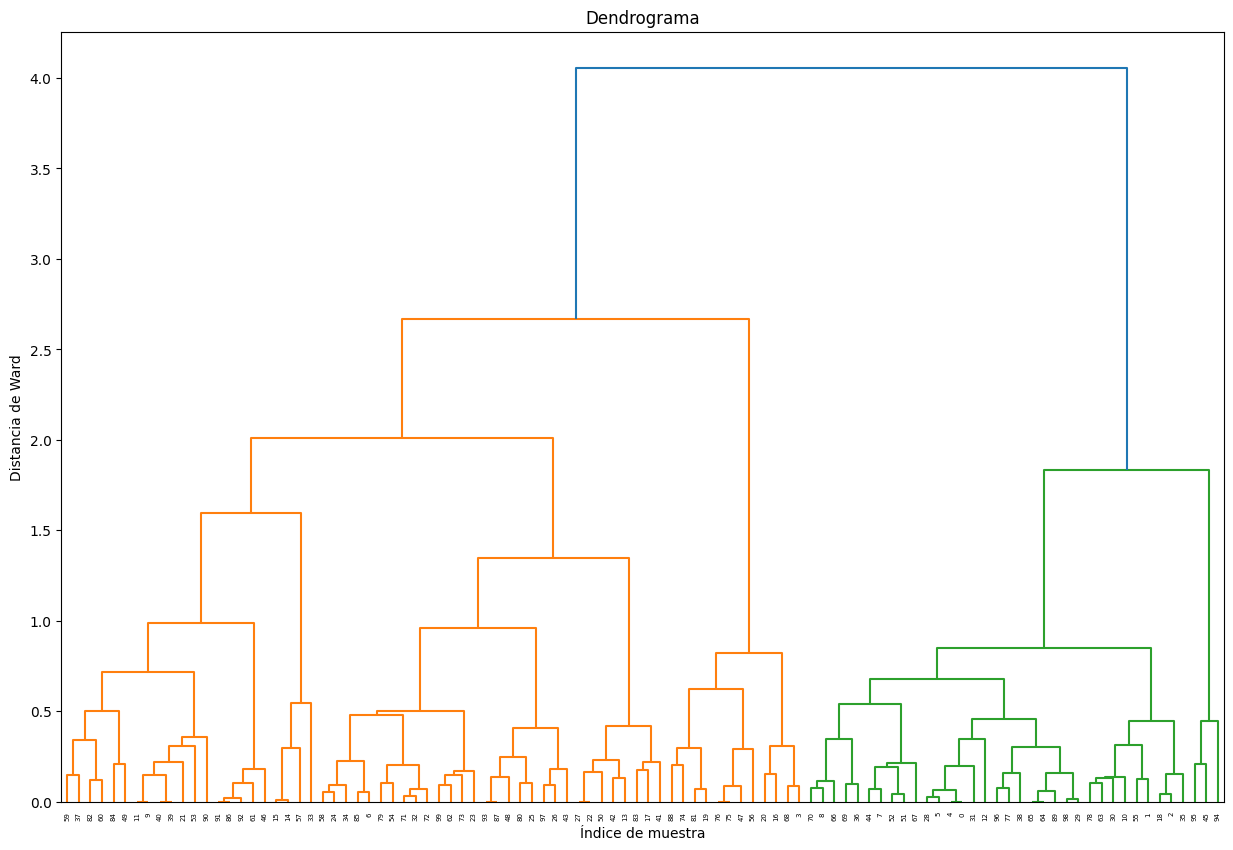

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage
sample_data = principal_components[:100]  # Reducir el tamaño de los datos para el dendrograma
linked_sample = linkage(sample_data, method='ward')

# Crear el dendrograma para la muestra reducida
plt.figure(figsize=(15, 10))
dendrogram(linked_sample, 
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia de Ward')
plt.show()